In [7]:
#IMPORT
import pandas as pd
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

In [8]:
train_data.columns

Index(['Unnamed: 0', 'text', 'labels'], dtype='object')

In [9]:
#LOADING DATA
train_data = pd.read_csv('/content/efcamdat_train_data.csv')
valid_data = pd.read_csv('/content/efcamdat_valid_data.csv')
test_data = pd.read_csv('/content/efcamdat_test_data.csv')

In [10]:
#SET UP CELL
checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = TFBertModel.from_pretrained(checkpoint, num_labels=6)

MAX_SEQUENCE_LENGTH = 128
BATCH_SIZE = 32

#tokenize text data for each split
train_encodings = bert_tokenizer(train_data["text"].tolist(), truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
valid_encodings = bert_tokenizer(valid_data["text"].tolist(), truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')
test_encodings = bert_tokenizer(test_data["text"].tolist(), truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors='tf')

def create_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'token_type_ids': encodings['token_type_ids'],
            'attention_mask': encodings['attention_mask']
        },
        labels
    ))
    return dataset

#create TF datasest with encoding and labels
train_dataset = create_dataset(train_encodings, train_data['labels'])
valid_dataset = create_dataset(valid_encodings, valid_data['labels'])
test_dataset = create_dataset(test_encodings, test_data['labels'])

#batching
train_dataset = train_dataset.shuffle(len(train_data)).batch(BATCH_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [11]:
#bert model architecture
def create_bert_classification_model(bert_model, num_classes=6, num_train_layers=0, hidden_size=200, dropout=0.5, learning_rate=0.00005):
    if num_train_layers == 0:
        bert_model.trainable = False
    elif num_train_layers == 12:
        bert_model.trainable = True
    else:
        retrain_layers = ['_' + str(11 - i) for i in range(num_train_layers)]
        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')

    bert_inputs = {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask}
    bert_out = bert_model(bert_inputs)
    pooler_token = bert_out[1]
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics=['accuracy'])
    return classification_model

bert_classification_model = create_bert_classification_model(bert_model, num_train_layers=12)

In [12]:
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                              

In [13]:
bert_classification_model_history = bert_classification_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=2,
)

Epoch 1/2
9362/9362 [==============================] - 3868s 406ms/step - loss: 0.1595 - accuracy: 0.9483 - val_loss: 0.0984 - val_accuracy: 0.9683
Epoch 2/2
9362/9362 [==============================] - 3795s 405ms/step - loss: 0.0852 - accuracy: 0.9736 - val_loss: 0.0946 - val_accuracy: 0.9702


In [14]:
from sklearn.metrics import classification_report

preds = bert_classification_model.predict(test_dataset)
test_labels = test_data['labels'].values

preds = tf.argmax(preds, axis=-1)
print(classification_report(test_labels, preds.numpy()))

1182/1182 [==============================] - 156s 124ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10103
           1       0.98      0.97      0.98      9890
           2       0.98      0.97      0.97      9972
           3       0.96      0.96      0.96      6204
           4       0.94      0.91      0.92      1446
           5       0.75      0.86      0.80       182

    accuracy                           0.97     37797
   macro avg       0.93      0.94      0.94     37797
weighted avg       0.97      0.97      0.97     37797



Text(220.72222222222223, 0.5, 'True')

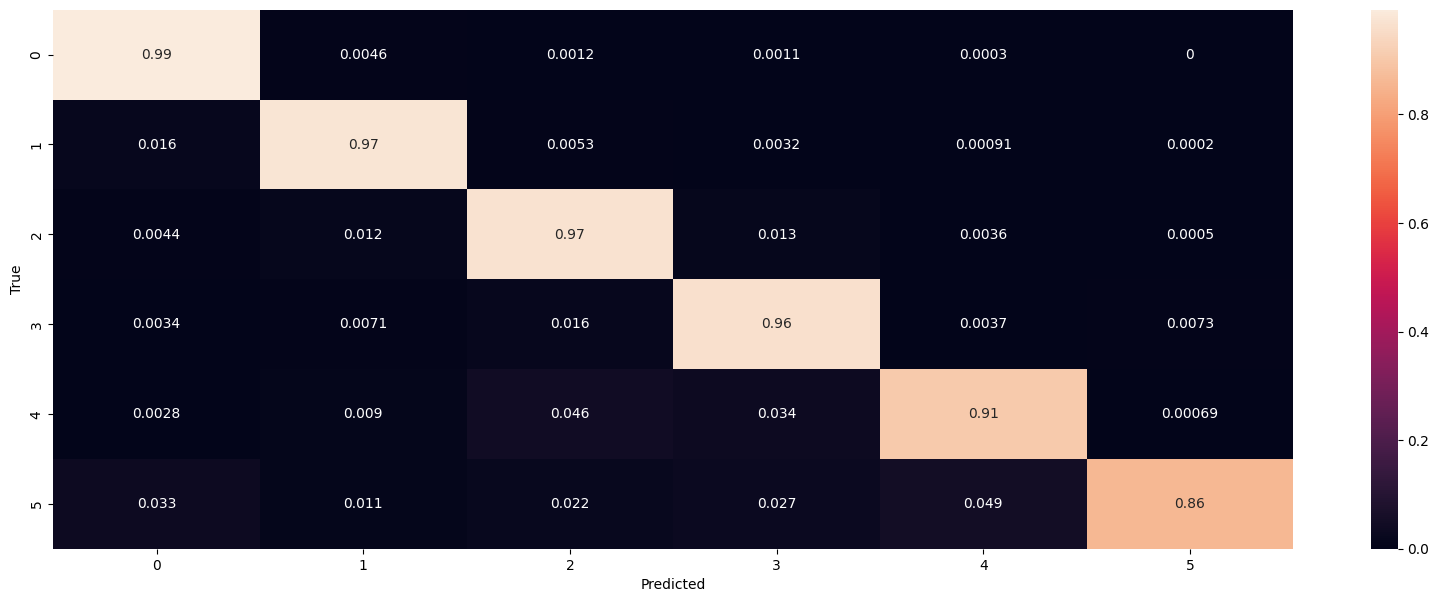

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = tf.math.confusion_matrix(test_labels, preds)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

In [16]:
results = bert_classification_model.evaluate(test_dataset)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

1182/1182 [==============================] - 148s 126ms/step - loss: 0.0899 - accuracy: 0.9721
Test Loss: 0.08985651284456253
Test Accuracy: 0.972061276435852


In [20]:
#save the model
bert_classification_model.save('bert_model.keras')

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [21]:
#download the model keras file onto my machine
from google.colab import files
files.download('bert_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>